In [1]:
import sys
sys.path.append('..')


file = '../data/fault_sim/results/cross_comparison.csv'
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
df = pd.read_csv(file)
thresh = 0.5

In [2]:


f_dict = {0: (-1, -1, -1), 1: (-1, -1, 1), 2: (-1, 1, -1), 3: (1, -1, -1), 4: (-1, 1, 1), 5: (1, 1, -1),
          6: (1, -1, 1), 7: (1, 1, 1)} # 1 : is a path, -1 : is a barrier.
f_dict_binary = {0: (0, 0, 0), 1: (0, 0, 1), 2: (0, 1, 0), 3: (1, 0, 0), 4: (0, 1, 1), 5: (1, 1, 0),
          6: (1, 0, 1), 7: (1, 1, 1)} # 1 : is a path, 0 : is not a path.
flt_classification = {1:{3,5,6,7}, 2:{2,4,5,7}, 3:{1,4,6,7}}
numerical_columns = [f'{j}' for j in range(8)]
def transform_df(df:pd.DataFrame, thresh = 0.3):
    new_df = df.copy()
    flt_id_series = df.index//10
    source_id_series = df.index%10
    binary_df = df > thresh
    new_df['thresh_nb'] = np.sum([binary_df[f'{i}'] == True for i in range(8)], axis = 0)
    new_df['flt_id'] = flt_id_series
    new_df['source_id'] = source_id_series
    
    for i, row in df.iterrows():
        
        flt_id = flt_id_series[i]
        new_df.loc[i,'thresh_acceptance'] = (row[str(flt_id)]>= thresh).astype(int)
        #first value method
        local_max = np.max(row[numerical_columns])
        new_df.loc[i,'first_value_acceptance'] =  (row[str(flt_id)] >= local_max - 0.05).astype(int)
        thresholded_bool = row[numerical_columns] >local_max - 0.05
        new_df.loc[i,'first_value_nb'] = np.sum(thresholded_bool)
   
        thresholded_scenarios = row[numerical_columns]
        fault_topology_array = list()
        for j in thresholded_scenarios.index:
            fault_topology = f_dict[int(j)]
            fault_topology_array.append(fault_topology)
        fault_topology_array = np.array(fault_topology_array)
        predicted_topology = np.average(fault_topology_array == 1, axis = 0, weights = thresholded_scenarios)
        new_df.loc[i,'f_1_true'], new_df.loc[i,'f_2_true'], new_df.loc[i,'f_3_true'] = tuple(f_dict_binary[flt_id])
        new_df.loc[i,'f_1_pred'], new_df.loc[i,'f_2_pred'], new_df.loc[i,'f_3_pred'] = predicted_topology 
        new_df.loc[i,'f_1_pred_bool'], new_df.loc[i,'f_2_pred_bool'], new_df.loc[i,'f_3_pred_bool'] = round(new_df.loc[i,'f_1_pred'],0), round(new_df.loc[i,'f_2_pred']), round(new_df.loc[i,'f_3_pred'])


                        
    return new_df

In [3]:
df = transform_df(df, thresh = thresh)

In [4]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true=df['f_2_true'], y_pred=df['f_2_pred_bool'])

(array([0.90243902, 0.92307692]),
 array([0.925, 0.9  ]),
 array([0.91358025, 0.91139241]),
 array([40, 40]))

0.34790191759097044 0.4971562744424972 0.5360501428929076


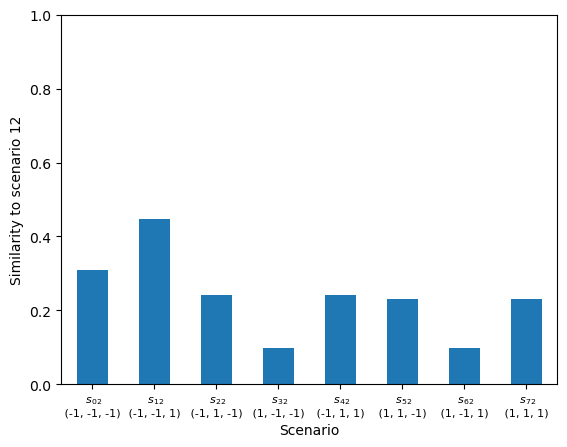

In [5]:
fig,ax = plt.subplots()
id = 12
source_id = int(str(id)[1])
df.loc[id
       ][numerical_columns].plot.bar(ax = ax)
ax.set_ylim(0,1)
xticklabels = [0]*8
scenario_id = source_id
xticklabels[0] = f" $s_{{0{scenario_id}}}$ \n {f_dict[0]} "
for k in range(1,8):
       scenario_id = source_id + k*10
       xticklabels[k] = f" $s_{{{scenario_id}}}$ \n {f_dict[k]} "
ax.set_xticklabels(xticklabels, rotation=0, fontsize = 8)
ax.set_ylabel(f'Similarity to scenario {id}')
ax.set_xlabel('Scenario')
print(df.loc[id, 'f_1_pred'],  df.loc[id, 'f_2_pred'], df.loc[id, 'f_3_pred'])

In [6]:
df2 = df.groupby('flt_id').mean()

In [7]:
df2

,Unnamed: 0,0,1,2,3,4,5,6,7,thresh_nb,...,first_value_nb,f_1_true,f_2_true,f_3_true,f_1_pred,f_2_pred,f_3_pred,f_1_pred_bool,f_2_pred_bool,f_3_pred_bool
flt_id,,,,,,,,,,,,,,,,,,,,,
0,4.5,0.421658,0.297372,0.168952,0.096046,0.168952,0.178639,0.096046,0.178639,0.3,...,1.0,0.0,0.0,0.0,0.351227,0.420519,0.475489,0.0,0.1,0.2
1,14.5,0.243912,0.413542,0.199882,0.092682,0.199882,0.196588,0.092682,0.196588,0.2,...,1.0,0.0,0.0,1.0,0.355828,0.458167,0.564340,0.0,0.2,1.0
2,24.5,0.121468,0.147430,0.755583,0.045974,0.755583,0.410311,0.045974,0.410311,2.4,...,2.4,0.0,1.0,0.0,0.328281,0.864216,0.504900,0.0,1.0,1.0
3,34.5,0.187168,0.215397,0.051894,0.806940,0.051894,0.178112,0.806940,0.178112,2.0,...,2.0,1.0,0.0,0.0,0.795486,0.182562,0.506009,1.0,0.0,0.8
4,44.5,0.133325,0.159767,0.796424,0.046723,0.796424,0.426962,0.046723,0.426962,2.4,...,2.4,0.0,1.0,1.0,0.322862,0.861668,0.504768,0.0,1.0,1.0
5,54.5,0.156218,0.170403,0.542599,0.186987,0.543150,0.444503,0.187806,0.444503,2.4,...,2.4,1.0,1.0,0.0,0.470930,0.722902,0.502655,0.3,0.8,0.8
6,64.5,0.174236,0.209663,0.052952,0.789396,0.052952,0.177010,0.789396,0.177010,2.0,...,2.0,1.0,0.0,1.0,0.797477,0.186241,0.507630,1.0,0.0,1.0
7,74.5,0.158444,0.178269,0.564485,0.185886,0.565323,0.462824,0.187486,0.462824,2.2,...,2.6,1.0,1.0,1.0,0.465463,0.737644,0.503981,0.3,0.8,1.0


In [8]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,thresh_nb,...,first_value_nb,f_1_true,f_2_true,f_3_true,f_1_pred,f_2_pred,f_3_pred,f_1_pred_bool,f_2_pred_bool,f_3_pred_bool
0,0,0.081882,0.412802,0.055164,0.157775,0.055164,0.078496,0.157775,0.078496,0,...,1.0,0.0,0.0,0.0,0.438532,0.248080,0.653551,0.0,0.0,1.0
1,1,0.089070,0.346617,0.059190,0.171759,0.059190,0.067838,0.171759,0.067838,0,...,1.0,0.0,0.0,0.0,0.463768,0.245877,0.624628,0.0,0.0,1.0
2,2,0.455234,0.230979,0.193915,0.073160,0.193915,0.210463,0.073160,0.210463,0,...,1.0,0.0,0.0,0.0,0.345611,0.492756,0.431683,0.0,0.0,0.0
3,3,0.508904,0.270637,0.208247,0.070133,0.208247,0.208247,0.070133,0.208247,1,...,1.0,0.0,0.0,0.0,0.317641,0.475235,0.432032,0.0,0.0,0.0
4,4,0.480734,0.309018,0.209837,0.067992,0.209837,0.209837,0.067992,0.209837,0,...,1.0,0.0,0.0,0.0,0.314806,0.475529,0.451358,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,0.124431,0.148668,0.738216,0.043067,0.738216,0.362250,0.043067,0.362250,2,...,2.0,1.0,1.0,1.0,0.316634,0.859683,0.504733,0.0,1.0,1.0
76,76,0.258347,0.272178,0.270572,0.282313,0.277741,0.681440,0.295104,0.681440,2,...,2.0,1.0,1.0,1.0,0.642667,0.633027,0.505596,1.0,1.0,1.0
77,77,0.125611,0.145927,0.748415,0.043968,0.748415,0.341394,0.043968,0.341394,2,...,2.0,1.0,1.0,1.0,0.303543,0.858424,0.504001,0.0,1.0,1.0
78,78,0.124991,0.144814,0.743855,0.044745,0.743855,0.309200,0.044745,0.309200,2,...,2.0,1.0,1.0,1.0,0.287129,0.854265,0.504020,0.0,1.0,1.0


In [9]:
np.sum(df['f_1_pred_bool'] - df['f_1_true'] == 0) 

66

In [10]:
df2.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', 'thresh_nb',
       'source_id', 'thresh_acceptance', 'first_value_acceptance',
       'first_value_nb', 'f_1_true', 'f_2_true', 'f_3_true', 'f_1_pred',
       'f_2_pred', 'f_3_pred', 'f_1_pred_bool', 'f_2_pred_bool',
       'f_3_pred_bool'],
      dtype='object')

In [11]:
def compute_recall_precision(thresh_value = 0.4, method = 'thresh', file_csv = 'df/cross.csv'):
    df_thresh = pd.read_csv(file_csv)
    df_thresh = transform_df(df_thresh, thresh = thresh_value)
    acceptance = f'{method}_acceptance'
    nb = f'{method}_nb'
    recall_dict, precision_dict = {}, {}
    for id in range(1,4):
        (precision_1, precision_2), (recall_1, recall_2), _,_ = precision_recall_fscore_support(y_true=df_thresh[f'f_{id}_true'], y_pred=df_thresh[f'f_{id}_pred_bool'])

        precision_dict[id], recall_dict[id] = (precision_1, precision_2), (recall_1, recall_2)
        
        
    
    recall, precision  = recall_dict, precision_dict
    nb_average = df_thresh[nb].mean()
    FP = ((df_thresh[nb] != 0)& (df_thresh[acceptance] == 0)  ).sum()
    TP = ((df_thresh[nb] != 0)& (df_thresh[acceptance] == 1)  ).sum()
    FN = ((df_thresh[nb] == 0)& (df_thresh[acceptance] == 0)  ).sum()
    success_rate  =  TP/(TP+FP+FN)
    ratio = success_rate/nb_average
    return [recall, precision, success_rate, nb_average, ratio]


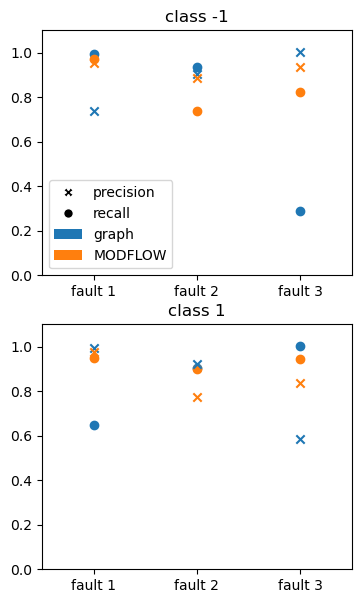

In [12]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
def plot_recall_precision(file_csv = file, color = 'C0', label = 'GRAPH'):

    recall_ig, precision_ig,_,_,_  = compute_recall_precision(thresh_value= 0, file_csv= file_csv)
    recall_mf, precision_mf,_,_,_  = compute_recall_precision(thresh_value= 0, file_csv= '../data/fault_sim/results/cross_comparison_mf.csv')
    fig, axs = plt.subplots(2,1, sharey=False, figsize=(4,7))
    for ax_id in range(2):
        for key, value in recall_ig.items():
            if key == 1:
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'o', c= color, label = label)
            else :
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'o', c= color)
        for key, value in recall_mf.items():
            if key == 1:
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'o', c= 'C1', label = label)
            else :
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'o', c= 'C1')
        for key, value in precision_ig.items():
            if key == 1:
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'x', c= color, label = label)
            else :
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'x', c= color)
        for key, value in precision_mf.items():
            if key == 1:
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'x', c= 'C1', label = label)
            else :
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'x', c= 'C1')
        axs[ax_id].set_ylim(0,1.1)
        axs[ax_id].set_xticks([1,2,3], labels = ["fault 1","fault 2","fault 3"])
        
        # axs[ax_id].set_xlabel('Fault id')
        axs[ax_id].set_xlim(0.5,3.5)
    
    axs[0].set_title('class -1')
    axs[1].set_title('class 1')
    legend_elements = [Line2D([0], [0], marker='X', color='w', label='precision',
                          markerfacecolor='black',markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='recall',
                          markerfacecolor='black',markersize=7),
                   Patch(facecolor='C0',
                         label='graph'),
                   Patch(facecolor='C1',
                         label='MODFLOW')
                   ]
    axs[0].legend(handles=legend_elements)
plot_recall_precision()
   


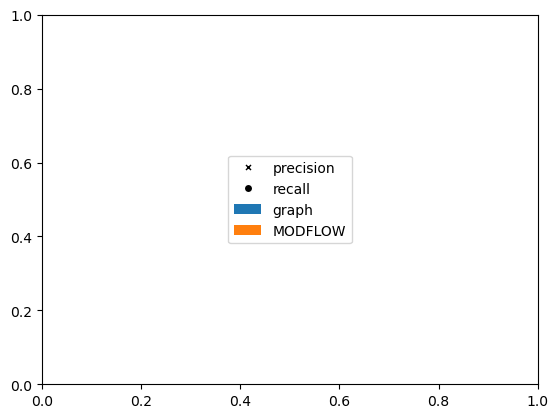

In [13]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Line2D([0], [0], marker='X', color='w', label='precision',
                          markerfacecolor='black'),
                   Line2D([0], [0], marker='o', color='w', label='recall',
                          markerfacecolor='black'),
                   Patch(facecolor='C0',
                         label='graph'),
                   Patch(facecolor='C1',
                         label='MODFLOW')
                   ]
fig,ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')


In [14]:
####
def plot_results(file_csv = file):  
    thresh_set = np.linspace(0,0.99,20)
    thresh_success, thresh_n, thresh_ratio = [],[],[]
    for thresh_value in thresh_set:
        recall_dict, precision_dict, success_rate, n ,ratio = compute_recall_precision(thresh_value , method = 'thresh', file_csv= file_csv)
        thresh_success.append(success_rate), thresh_n.append(n), thresh_ratio.append(ratio)
    
    first_value_recall, first_value_precision, first_value_success, first_value_n, first_value_ratio = compute_recall_precision(method = 'first_value', file_csv= file_csv)

    fig,ax = plt.subplots()
    X = np.linspace(0,8,9)
    sc = ax.scatter(thresh_n, thresh_success, c = thresh_set, marker = 'o', label = r'$g_{\lambda}$', cmap = 'cividis')
    fig.colorbar(sc,ax = ax, label = r'Threshold $\lambda$')
    ax.scatter(first_value_n, first_value_success, marker = 'x', c = 'red', label = r'$u$' )
    

    
    ax.scatter(X, (1/8)*X, marker= '+', label = r'$h_{k}$', c = 'black')
    ax.legend()
    # ax.set_title('success')
    ax.set_ylabel(r'$\bar{Y}(f)$')
    ax.set_xlabel(r'$\bar{w}(f)$')
    ax.legend()
    
    fig.tight_layout()



/tmp/ipykernel_2894526/949048275.py:20: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average
/tmp/ipykernel_2894526/949048275.py:20: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average
/tmp/ipykernel_2894526/949048275.py:20: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average


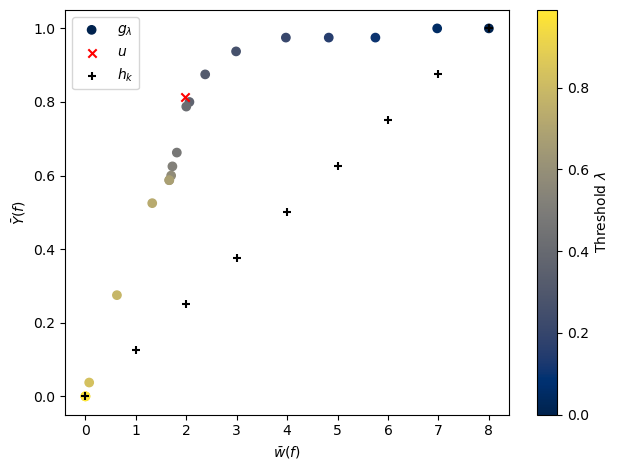

In [15]:
plot_results()